In [1]:
# set up SageMaker environment
import sagemaker, boto3

sess = boto3.Session()
sm = sess.client('sagemaker')
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session(boto_session=sess)

In [2]:
print(role)

arn:aws:iam::844357513200:role/AmazonSageMaker-FullAccessRole


In [3]:
# load packages
import time, os, sys
import numpy as np
import pandas as pd
from PIL import Image
from numpy import asarray
#import pickle as pkl

import s3fs
fs = s3fs.S3FileSystem()

from keras.utils import np_utils
from keras_preprocessing.image import ImageDataGenerator
import tensorflow as tf

from sagemaker.tensorflow import TensorFlow

Using TensorFlow backend.


In [4]:
# path to the data on S3 bucket
bucket = "sagemaker-michaelwu-ma5852"
subfolder = 'src/Covid19-dataset'
input_data_train_path = f'{subfolder}/train'
input_data_test_path = f'{subfolder}/test'

In [5]:
s3 = sess.resource('s3')
my_bucket = s3.Bucket(bucket)

In [6]:
'''
    loading all images in a numpy array with labels
'''
def load_image_from_folder(path, basewidth, hsize):
    filenames = []
    
    # temp lists
    image_list = []
    labels = []
    
    for my_bucket_object in my_bucket.objects.filter(Prefix=path):
        filenames.append(bucket + '/' + my_bucket_object.key)
    
    for image_path in filenames:
        # get labels from image path
        label = image_path.split("/")[-2]
        labels.append(label)
        
        # converting image and resize it
        img = Image.open(fs.open(image_path)).convert('L')
        img = img.resize((basewidth, hsize), Image.ANTIALIAS)
        frame = asarray(img)
        
        # appending array of image to image_list
        image_list.append(frame)
        
    '''
        Tensorflow needs image channels last, e.g. (width, height, channels)
        so we need to convert images to array channel last format , which can be done using zero matrix
        we first create a dummy zero matrix of same shape with single channel
    '''
    image_list_1 = np.zeros(shape=(np.array(image_list).shape[0], hsize, basewidth, 1))
    for i in range(np.array(image_list).shape[0]):
        # for each sub matrix will be replaced with respective images array
        image_list_1[i, :, :, 0] = image_list[i]
    
    return np.array(image_list_1), np.array(labels)    

In [7]:
# load image data
X_train, y_train = load_image_from_folder(input_data_train_path, 28, 28)
X_test, y_test = load_image_from_folder(input_data_test_path, 28, 28)

In [8]:
# create local directory for data and save the training and test data there
os.makedirs("./data", exist_ok=True)
os.makedirs("./output", exist_ok=True)
np.savez('./data/training', image=X_train, label=y_train)
np.savez('./data/test', image=X_test, label=y_test)

In [9]:
%%writefile train_cnn_baseline.py
# import packages
import argparse, os
import numpy as np

import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-q", "-m", "pip", "install", package])

install('matplotlib')

import matplotlib.pyplot as plt

import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


if __name__ == '__main__':
    # Hyperparameters
    parser = argparse.ArgumentParser()
    parser.add_argument('--epochs', type=int, default=10)
#     parser.add_argument('--batch-size', type=int, default=1)
    
    parser.add_argument('--gpu-count', type=int, default=os.environ['SM_NUM_GPUS'])
    parser.add_argument('--model-dir', type=str, default=os.environ['SM_MODEL_DIR'])
    parser.add_argument('--training', type=str, default=os.environ['SM_CHANNEL_TRAINING'])
    parser.add_argument('--test', type=str, default=os.environ['SM_CHANNEL_TEST'])
    parser.add_argument('--output', type=str, default=os.environ['SM_OUTPUT_DATA_DIR'])
    
    args, _ = parser.parse_known_args()
    
    epochs = args.epochs
#     batch_size = args.batch_size
    
    gpu_count = args.gpu_count
    model_dir = args.model_dir
    training_dir = args.training
    test_dir = args.test
    output_dir = args.output
    
    X_train = np.load(os.path.join(training_dir, 'training.npz'))['image']
    y_train = np.load(os.path.join(training_dir, 'training.npz'))['label']
    X_test = np.load(os.path.join(test_dir, 'test.npz'))['image']
    y_test = np.load(os.path.join(test_dir, 'test.npz'))['label']
    
    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_test shape: {y_test.shape}')
    
    def vis_training(hlist, start=1):
        """
            This function will help to visualize the loss, val_loss, accuracy etc.
        """
        # getting history of all kpi for each epochs
        loss = np.concatenate([hlist.history['loss']])
        val_loss = np.concatenate([hlist.history['val_loss']])
        acc = np.concatenate([hlist.history['accuracy']])
        val_acc = np.concatenate([hlist.history['val_accuracy']])
        epoch_range = range(1,len(loss)+1)

        # Block for training vs validation loss
        plt.figure(figsize=[12,6])
        plt.subplot(1,2,1)
        plt.plot(epoch_range[start-1:], loss[start-1:], label='Training Loss')
        plt.plot(epoch_range[start-1:], val_loss[start-1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.legend()
        # Block for training vs validation accuracy
        plt.subplot(1,2,2)
        plt.plot(epoch_range[start-1:], acc[start-1:], label='Training Accuracy')
        plt.plot(epoch_range[start-1:], val_acc[start-1:], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.savefig(os.path.join(output_dir, 'train_log.png'))
    
    
    # Since this is a small dataset, we need to generate some data to increase accuracy
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False, 
        vertical_flip=False
    )
    
    # Converting labels in int format as TF accepts only int in targets class
    y_train[y_train == 'Covid'] = 0
    y_train[y_train == 'Normal'] = 1
    
    y_test[y_test == 'Covid'] = 0
    y_test[y_test == 'Normal'] = 1
    
    # converting to int format
    num_classes = 2
    y_train = to_categorical(y_train.astype('int'), num_classes)
    y_test = to_categorical(y_test.astype('int'), num_classes)
    
    # adding extra data from datagen
    train_gen = datagen.flow(X_train, y_train)
    test_gen = datagen.flow(X_test, y_test)
    
    # define model structure
    model = tf.keras.Sequential()
    ## 1st convolution layer
    ### convolutional layer with 64 filters
    model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(28, 28, 1)))
    ## downsample using a max pooling layer, which feeds into the next set of convolutional layers
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    ## 2nd convolultion layer
    ## convolutional layer with 32 filters
    model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
    # flatten and classify
    ## flattern spacial information into a vector, and learn the final probability distribution for each class
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(2, activation='sigmoid')) # number of neurons at the output layer = number of classes of the target (2)
    # Take a look at the model summary
    model.summary()
    
    if gpu_count > 1:
        model = multi_gpu_model(model, gpus=gpu_count)
        
    # compile the model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    # early stopping
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, verbose=1)
    
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.local_variables_initializer())

    train_log = model.fit(train_gen,
                          validation_data = test_gen,
                          #batch_size=8,
                          epochs=epochs,
                          callbacks=[es]
                        )

    # evaluate on training data
    score_train = model.evaluate(train_gen, verbose=0)
    print(f'Training set loss is: {score_train[0]}')
    print(f'Training set accuracy is: {score_train[1]}')
    print(f'Training set precision is: {score_train[2]}')
    print(f'Training set recall is: {score_train[3]}')        
    
    # evaluate on test data
    score = model.evaluate(test_gen, verbose=0)
    print(f'Test set loss is: {score[0]}')
    print(f'Test set accuracy is: {score[1]}')
    print(f'Test set precision is: {score[2]}')
    print(f'Test set recall is: {score[3]}')

    # Visuals of loss and accuracy
    vis_training(train_log, start=1)
    
    # save Keras model for Tensorflow Serving
    model.save(os.path.join(model_dir, '1'))    
    

Overwriting train_cnn_baseline.py


In [10]:
'''
    train model locally
'''
# set environment variables
local_training_input_path = 'file://data/training.npz'
local_test_input_path = 'file://data/test.npz'
output = 'file://output'

tf_estimator_local = TensorFlow(entry_point='train_cnn_baseline.py',
                         role=role,
                         source_dir='.',
                         instance_count=1, # the number of EC2 isntance to use
                         instance_type='local', # type of EC2 instance to use local
                         framework_version='2.1.0', # tensorflow version
                         py_version='py3',
                         script_mode=True, #enable to use python script to train the model
                         hyperparameters={'epochs':1}, # only need 1 epoch to test whether our code is working or not
                         output_path=f's3://{bucket}/output/')

In [11]:
# train model locally to see whether the code is working or not
tf_estimator_local.fit({'training': local_training_input_path, 'test': local_test_input_path})

Creating p1kqyobo0c-algo-1-oqo60 ... 
Creating p1kqyobo0c-algo-1-oqo60 ... done
Attaching to p1kqyobo0c-algo-1-oqo60
p1kqyobo0c-algo-1-oqo60 | 2022-02-28 09:49:39,663 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
p1kqyobo0c-algo-1-oqo60 | 2022-02-28 09:49:39,673 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
p1kqyobo0c-algo-1-oqo60 | 2022-02-28 09:49:43,480 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
p1kqyobo0c-algo-1-oqo60 | 2022-02-28 09:49:43,505 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
p1kqyobo0c-algo-1-oqo60 | 2022-02-28 09:49:43,528 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
p1kqyobo0c-algo-1-oqo60 | 2022-02-28 09:49:43,541 sagemaker-containers INFO     Invoking user script
p1kqyobo0c-algo-1-oqo60 | 
p1kqyobo0c-algo-1-oqo60 | Training Env:
p1kqyobo0c-algo-1-oqo60 | 
p1kqyobo0c-algo-1-oqo60 | {
p1kqyobo0c-al

Failed to delete: /tmp/tmpyam5sssp/algo-1-oqo60 Please remove it manually.


===== Job Complete =====


In [12]:
'''
    train model on AWS
'''
# upload data to s3 bucket
prefix = 'A3_preprocessed_data'

training_input_path = sagemaker_session.upload_data(path='data/training.npz', bucket=bucket, key_prefix=prefix+'/training')

test_input_path = sagemaker_session.upload_data(path='data/test.npz', bucket=bucket, key_prefix=prefix+'/test')

print(training_input_path)
print(test_input_path)

s3://sagemaker-michaelwu-ma5852/A3_preprocessed_data/training/training.npz
s3://sagemaker-michaelwu-ma5852/A3_preprocessed_data/test/test.npz


In [14]:
tf_estimator_baseline_awb = TensorFlow(entry_point='train_cnn_baseline.py',
                                       base_job_name='A3-CNN-baseline',
                                       role=role,
                                       source_dir='.',
                                       instance_count=1, # the number of EC2 isntance to use
                                       instance_type='ml.m5.4xlarge',
                                       framework_version='2.1.0', # tensorflow version
                                       py_version='py3',
                                       script_mode=True, #enable to use python script to train the model
                                       hyperparameters={'epochs':30},
                                       output_path=f's3://{bucket}/output/'
                                      )

In [15]:
tf_estimator_baseline_awb.fit({'training': training_input_path, 'test': test_input_path})

2022-02-28 09:50:42 Starting - Starting the training job...
2022-02-28 09:50:44 Starting - Launching requested ML instancesProfilerReport-1646041831: InProgress
.........
2022-02-28 09:52:23 Starting - Preparing the instances for training...
2022-02-28 09:53:06 Downloading - Downloading input data...
2022-02-28 09:53:43 Training - Training image download completed. Training in progress..2022-02-28 09:53:33,900 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2022-02-28 09:53:33,907 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-28 09:53:46,138 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-28 09:53:46,154 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-28 09:53:46,170 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-28 09:53:46,180 sagemaker-containers INFO     Invoking user script
Training Env:
{
  

In [15]:
'''
    hyperparameter tuning on the baseline nn model
'''
from sagemaker.tuner import IntegerParameter

hyperparameter_ranges = {
    'epochs': IntegerParameter(5, 300),
}

print(hyperparameter_ranges)

{'epochs': <sagemaker.parameter.IntegerParameter object at 0x7f7808940cc0>}


In [16]:
objective_metric_name = 'validation_accuracy' # name of the metric for evaluating training jobs

objective_type = 'Maximize'

metric_definitions = [
    {'Name': 'training_loss', 'Regex': 'loss: ([0-9\\.]+)'},
    {'Name': 'training_accuracy', 'Regex': 'accuracy: ([0-9\\.]+)'},
    {'Name': 'validation_loss', 'Regex': 'val_loss: ([0-9\\.]+)'},
    {'Name': 'validation_accuracy', 'Regex': 'val_accuracy: ([0-9\\.]+)'},
    {'Name': 'training_precision', 'Regex': 'precision: ([0-9\\.]+)'},
    {'Name': 'training_recall', 'Regex': 'recall: ([0-9\\.]+)'}
]

In [17]:
# configure a training job using the Tensorflow estimator
tf_estimator_baseline_hpo_awb = TensorFlow(entry_point='train_cnn_baseline.py',
                                           role=role,
                                           instance_count=1,
                                           instance_type='ml.m5.4xlarge',
                                           framework_version='2.1.0',
                                           py_version='py3',
                                           script_mode=True
                                          )

from sagemaker.tuner import HyperparameterTuner

tuner = HyperparameterTuner(tf_estimator_baseline_hpo_awb,
                           objective_metric_name,
                           hyperparameter_ranges,
                           metric_definitions,
                           max_jobs=6,
                           max_parallel_jobs=2,
                           objective_type=objective_type,
                           base_tuning_job_name='HPO-A3-CNN-baseline')

In [25]:
# fit is used to train the model
tuner.fit({'training': training_input_path, 'test': test_input_path})

.....................................................................................................................................!


In [16]:
# inspect jobs with AWS
from sagemaker.tuner import HyperparameterTuner
tuner = HyperparameterTuner.attach("HPO-A3-CNN-baseline-220224-0232")
analytics = tuner.analytics()
df_hpo_res = analytics.dataframe()
df_hpo_res

,epochs,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,40.0,HPO-A3-CNN-baseline-220224-0232-006-926cdfa2,Completed,0.8696,2022-02-24 02:41:20+00:00,2022-02-24 02:42:22+00:00,62.0
1,36.0,HPO-A3-CNN-baseline-220224-0232-005-5c0b694f,Completed,0.9239,2022-02-24 02:42:28+00:00,2022-02-24 02:43:30+00:00,62.0
2,290.0,HPO-A3-CNN-baseline-220224-0232-004-069d52f7,Completed,0.9565,2022-02-24 02:38:06+00:00,2022-02-24 02:39:36+00:00,90.0
3,247.0,HPO-A3-CNN-baseline-220224-0232-003-e171cf34,Completed,0.9565,2022-02-24 02:38:06+00:00,2022-02-24 02:39:28+00:00,82.0
4,37.0,HPO-A3-CNN-baseline-220224-0232-002-4ab19537,Completed,0.9891,2022-02-24 02:35:05+00:00,2022-02-24 02:36:19+00:00,74.0
5,254.0,HPO-A3-CNN-baseline-220224-0232-001-c3318f1e,Completed,1.0000,2022-02-24 02:35:09+00:00,2022-02-24 02:36:08+00:00,59.0


In [17]:
# select the best job with the highest accuracy
best_job = df_hpo_res.sort_values('FinalObjectiveValue', ascending=False)[:1]

best_job

,epochs,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
5,254.0,HPO-A3-CNN-baseline-220224-0232-001-c3318f1e,Completed,1.0,2022-02-24 02:35:09+00:00,2022-02-24 02:36:08+00:00,59.0


In [18]:
'''
    train baseline model on AWS using the optimal hyperparameters
'''
# upload data to s3 bucket
prefix = 'A3_preprocessed_data'

training_input_path = sagemaker_session.upload_data(path='data/training.npz', bucket=bucket, key_prefix=prefix+'/training')

test_input_path = sagemaker_session.upload_data(path='data/test.npz', bucket=bucket, key_prefix=prefix+'/test')

print(training_input_path)
print(test_input_path)

s3://sagemaker-michaelwu-ma5852/A3_preprocessed_data/training/training.npz
s3://sagemaker-michaelwu-ma5852/A3_preprocessed_data/test/test.npz


In [19]:
baseline_optimal_epochs = int(best_job['epochs'].values[0])

tf_estimator_baseline_hpo_tuned_awb = TensorFlow(entry_point='train_cnn_baseline.py',
                                                 base_job_name='A3-CNN-baseline-tuned',
                                                 role=role,
                                                 source_dir='.',
                                                 instance_count=1, # the number of EC2 isntance to use
                                                 instance_type='ml.m5.4xlarge',
                                                 framework_version='2.1.0', # tensorflow version
                                                 py_version='py3',
                                                 script_mode=True, #enable to use python script to train the model
                                                 hyperparameters={'epochs':baseline_optimal_epochs},
                                                 output_path=f's3://{bucket}/output/'
                                            )

In [20]:
tf_estimator_baseline_hpo_tuned_awb.fit({'training': training_input_path, 'test': test_input_path})

2022-02-28 09:56:22 Starting - Starting the training job...
2022-02-28 09:56:39 Starting - Preparing the instances for trainingProfilerReport-1646042172: InProgress
......
2022-02-28 09:57:42 Downloading - Downloading input data...
2022-02-28 09:58:21 Training - Training image download completed. Training in progress..2022-02-28 09:58:23,595 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2022-02-28 09:58:23,602 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-28 09:58:25,483 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-28 09:58:25,499 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-28 09:58:25,513 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-02-28 09:58:25,523 sagemaker-containers INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
 

In [23]:
'''
    deploy hyperparameter tuned baseline model
'''
tf_tuned_baseline_endpoint_name = 'A3-keras-tf-tuned-baseline-cnn-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

predictor_tuned_baseline_awb = tf_estimator_baseline_hpo_tuned_awb.deploy(initial_instance_count=1,
                                                                          instance_type='ml.m5.4xlarge',
                                                                          endpoint_name=tf_tuned_baseline_endpoint_name
                                                                         )

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


----!

In [1]:
'''
    Transfer learning
'''
# set up SageMaker environment
import sagemaker, boto3

sess = boto3.Session()
sm = sess.client('sagemaker')
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session(boto_session=sess)

In [2]:
# VGG16 model used for transfer learning for this assignment
import sys
import os
from matplotlib import pyplot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras_preprocessing.image import ImageDataGenerator

In [3]:
# define model
def define_model():
    # load DenseNet201 model
    model = VGG16(include_top=False, input_shape=(224, 224, 3))
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    # add new classifier layers
    flat1 = Flatten()(model.layers[-1].output)
    class1 = Dense(64, activation='relu')(flat1)
    output = Dense(1, activation='sigmoid')(class1)
    
    # define new model
    model = Model(inputs=model.inputs, outputs=output)
    
    # compile model
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

In [4]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy')
	pyplot.plot(history.history['acc'], color='blue', label='train')
	pyplot.plot(history.history['val_acc'], color='orange', label='test')
	# save plot to file
	filename = sys.argv[0].split('/')[-1]
	pyplot.savefig(filename + '_plot.png')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Found 181 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


[2022-02-24 05:36:17.046 ip-172-16-66-87:733 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-02-24 05:36:17.168 ip-172-16-66-87:733 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
Epoch 1/30
6/6 [==============================] - 82s 14s/step - loss: 24.7252 - acc: 0.5801 - precision: 0.4634 - recall: 0.5429 - val_loss: 3.5905 - val_acc: 0.5000 - val_precision: 0.4651 - val_recall: 1.0000
Epoch 2/30
6/6 [==============================] - 71s 12s/step - loss: 1.2931 - acc: 0.7569 - precision: 0.6327 - recall: 0.8857 - val_loss: 0.1635 - val_acc: 0.9565 - val_precision: 1.0000 - val_recall: 0.9000
Epoch 3/30
6/6 [==============================] - 

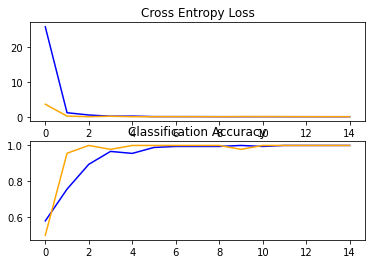

In [5]:
# training
model = define_model()

# create data generator
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image 
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=False, 
    vertical_flip=False
)

# prepare iterator
train_gen = datagen.flow_from_directory('data_transfer_learning/train/', class_mode='binary', target_size=(224, 224))
test_gen = datagen.flow_from_directory('data_transfer_learning/test/', class_mode='binary', target_size=(224, 224))

# early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='acc', mode='max', patience=5, verbose=1)

with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.local_variables_initializer())

# fit model
history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen),
                    validation_data=test_gen,
                    validation_steps=len(test_gen),
                    epochs=30, 
                    verbose=1,
                    callbacks=[es]
                   )

# evaluate model
score = model.evaluate(test_gen, steps=len(test_gen), verbose=0)
print(f'Test set accuracy from Transfer Learning with VGG16 is: {score[1]}')

# learning curves
summarize_diagnostics(history)